# Labeling school budget data

Goal: Perform NLP on school budget data to predict accurate labels for the expenditure category using multiclass classification models from scikit learn. 

We will build a human-in-the-loop system by assigning a probability of labels to each line item.  

Author: Sushant N. More

Data from [DrivenData](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/data/) 

Ref: Datacamp

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

In [35]:
df_train = pd.read_csv('TrainingData.csv', index_col=0)

In [36]:
df_train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [38]:
df_train.tail()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
109283,Professional Development,ISPD,Shared Services,Non-School,Unspecified,Instructional Coach,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,WORKSHOP PARTICIPANT,...,NaN,STAFF DEV AND INSTR MEDIA,NaN,INST STAFF TRAINING SVCS,NaN,NaN,48.620000,NaN,GENERAL FUND,STAFF DEV AND INSTR MEDIA
102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,...,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN
433672,Library & Media,Instruction,School on Central Budgets,Non-School,Unspecified,Librarian,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,ED RESOURCE SERVICES,NaN,NON-PROJECT,NaN,OFFICE/ADMINISTRATIVE SUPPORT,4020.290000,MEDIA SUPPORT SERVICES,NaN,INSTRUCTIONAL STAFF
415831,Substitute Compensation,Instruction,School Reported,School,Poverty,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Substitute Professionals,...,Inservice Substitute Teachers Grant Funded,School,NaN,Instruction,Instruction And Curriculum,CERTIFIED SUBSTITUTE,46.530000,Accelerated Education,"""Title Part A Improving Basic Programs""",MISCELLANEOUS


In [39]:
df_train.columns

Index(['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status',
       'Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'FTE', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Total',
       'Program_Description', 'Fund_Description', 'Text_1'],
      dtype='object')

In [40]:
df_train.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

The variance in expenditure is high. Makes sense---some purchases are cheap, some are expensive. 

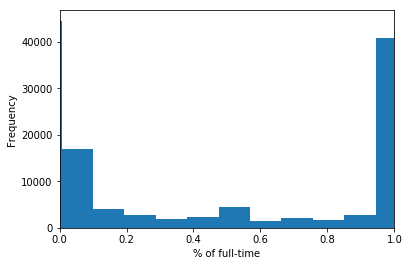

In [41]:
df_train['FTE'].dropna().plot(kind = 'hist', xlim = [0, 1], bins = 500);
plt.xlabel('% of full-time');

Bi-modal distribution! 

Making variables categorical.

First let's look at object variables. 

In [42]:
df_train.dtypes

Function                   object
Use                        object
Sharing                    object
Reporting                  object
Student_Type               object
Position_Type              object
Object_Type                object
Pre_K                      object
Operating_Status           object
Object_Description         object
Text_2                     object
SubFund_Description        object
Job_Title_Description      object
Text_3                     object
Text_4                     object
Sub_Object_Description     object
Location_Description       object
FTE                       float64
Function_Description       object
Facility_or_Department     object
Position_Extra             object
Total                     float64
Program_Description        object
Fund_Description           object
Text_1                     object
dtype: object

In [43]:
df_train.dtypes.value_counts()

object     23
float64     2
dtype: int64

The object types are slow and don't work well with ML algorithms.

For each of these rows, ERS attaches one label from each of 9 different categories as explained [here.](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#labels_list)

Next we convert these labels into categories type.

In [44]:
labels = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [45]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating


In [46]:
df_train[labels].shape

(400277, 9)

In [47]:
set(df_train.columns) - set(labels)

{'FTE',
 'Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4',
 'Total'}

In [48]:
categorize_label = lambda lab: lab.astype('category')

In [49]:
df_train[labels] = df_train[labels].apply(categorize_label, axis = 'rows')

In [50]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating


In [52]:
df_train[labels].dtypes

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object

In [53]:
df_train[labels].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 9 columns):
Function            400277 non-null category
Use                 400277 non-null category
Sharing             400277 non-null category
Reporting           400277 non-null category
Student_Type        400277 non-null category
Position_Type       400277 non-null category
Object_Type         400277 non-null category
Pre_K               400277 non-null category
Operating_Status    400277 non-null category
dtypes: category(9)
memory usage: 6.5 MB


Counting unique labels

In [54]:
df_train[labels].nunique()

Function            37
Use                  8
Sharing              5
Reporting            3
Student_Type         9
Position_Type       25
Object_Type         11
Pre_K                3
Operating_Status     3
dtype: int64

In [55]:
type(df_train[labels].nunique())

pandas.core.series.Series

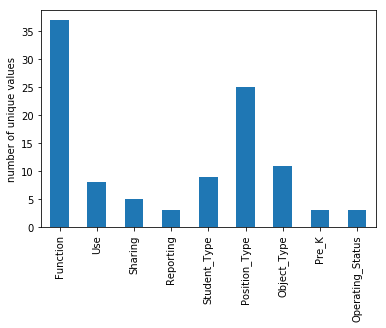

In [56]:
df_train[labels].nunique().plot(kind = 'bar');
plt.ylabel('number of unique values');

**Model building**

As a first pass build a simple model using just the numeric columns.

In [57]:
numeric_data = df_train.select_dtypes(include = [float]).fillna(-1000)
# filling NaNs with a large negative number

In [58]:
numeric_columns = list(df_train.select_dtypes(include = [float]).columns.values)

In [59]:
numeric_columns

['FTE', 'Total']

In [60]:
numeric_data.head()

,FTE,Total
134338,1.0,50471.810
206341,-1000.0,3477.860
326408,1.0,62237.130
364634,-1000.0,22.300
47683,-1000.0,54.166


In [61]:
NUMERIC_COLUMNS

NameError: name 'NUMERIC_COLUMNS' is not defined

In [62]:
df_train[numeric_columns].head()

,FTE,Total
134338,1.0,50471.810
206341,NaN,3477.860
326408,1.0,62237.130
364634,NaN,22.300
47683,NaN,54.166


In [63]:
df_label_dummies = pd.get_dummies(df_train[labels])

In [64]:
df_label_dummies.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
206341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
326408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
364634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [65]:
df_label_dummies.shape

(400277, 104)

In [66]:
df_train[labels].shape

(400277, 9)

** Doing the test-train split **

Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. A way to do this is using StratifiedShuffleSplit. However scikit-learn's StratifiedShuffleSplit works only for one target variable. Here we have 104 of them! 

To accomplish the stratified shuffle split for multiple target variable, I use the function written by [Peter Bull.](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py)

In [67]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

The function multilabel_train_test_split() makes sure that at least min_count examples appear in each split. 

In [68]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data,
                                                               df_label_dummies,
                                                               size=0.2, 
                                                               seed=123)

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB


In [70]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB


In [71]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB


In [72]:
y_train.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
326408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
364634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
229958,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [73]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 8.6 MB


Training Model

In [74]:
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

OneVsRestClassifier treats each columns of y independently. Essentially, it fits a separate classifier for each of the columns. 

In [77]:
clf.score(X_test, y_test)

0.0

Pretty dismal score. But not very surprising given that we threw out most of our data. Let's go ahead and test the predictions on the holdout test data. Note that because we are developing 'human-in-the-loop' system, we wanna output the probabilities. 

In [78]:
holdout = pd.read_csv('TestData.csv', index_col=0)

/Users/sushantmore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
holdout.head()

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
180042,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN
28872,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN
186915,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN
412396,Professional Salaries,Bilingual Education,NaN,T-EL 2ND BIL,NaN,General,School,1.0,Instruction,NaN,NaN,69729.263191,NaN,NaN,General Fund,NaN
427740,Salaries for Support Personnel,Undistributed,NaN,CLERK III- SCH,NaN,General,School,1.0,School Leadership,NaN,NaN,29492.834215,NaN,NaN,General Fund,NaN


In [80]:
prediction = clf.predict_proba(holdout[numeric_columns].fillna(-1000))

/Users/sushantmore/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [81]:
prediction

array([[3.58422797e-02, 6.46624380e-03, 8.29889897e-04, ...,
        1.69612505e-01, 1.99296715e-02, 8.10542978e-01],
       [3.58482728e-02, 6.46610323e-03, 8.29901972e-04, ...,
        1.69607062e-01, 1.99300220e-02, 8.10552526e-01],
       [1.20946821e-01, 9.06524483e-03, 1.58707950e-03, ...,
        9.59309999e-02, 5.10388042e-02, 9.28360476e-01],
       ...,
       [1.22222570e-01, 9.05171601e-03, 1.58866973e-03, ...,
        9.57003802e-02, 5.10986945e-02, 9.28644820e-01],
       [1.22275131e-01, 9.04889685e-03, 1.58830780e-03, ...,
        9.57066370e-02, 5.10808770e-02, 9.28635308e-01],
       [1.22159718e-01, 9.05011410e-03, 1.58816455e-03, ...,
        9.57273883e-02, 5.10754822e-02, 9.28609739e-01]])

In [82]:
prediction.shape

(50064, 104)

In [83]:
holdout.shape

(50064, 16)

In [84]:
df_train.shape

(400277, 25)

Note 25 - 16 = 9. We have 9 taget variables (before applying the get_dummies).

Let's write predictions to a dataframe

In [85]:
prediction_df = pd.DataFrame(data = prediction, columns=pd.get_dummies(df_train[labels]).columns, \
                            index = holdout.index)

In [87]:
prediction_df.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
180042,0.035842,0.006466,0.000830,0.023918,0.008916,0.000147,0.032077,0.024406,0.052099,0.000069,...,0.010729,0.036846,0.116126,0.017360,0.831241,0.141031,0.027749,0.169613,0.019930,0.810543
28872,0.035848,0.006466,0.000830,0.023919,0.008916,0.000147,0.032078,0.024406,0.052102,0.000069,...,0.010728,0.036959,0.116164,0.017361,0.831233,0.141041,0.027751,0.169607,0.019930,0.810553
186915,0.120947,0.009065,0.001587,0.028599,0.016042,0.056023,0.043858,0.031715,0.113907,0.017065,...,0.005622,0.136221,0.135391,0.016041,0.501655,0.472173,0.098601,0.095931,0.051039,0.928360
412396,0.120381,0.009071,0.001586,0.028573,0.016044,0.055813,0.043808,0.031688,0.113723,0.017034,...,0.005630,0.125189,0.134056,0.016029,0.502143,0.471525,0.098399,0.096034,0.051012,0.928233
427740,0.121725,0.009057,0.001588,0.028634,0.016038,0.056310,0.043926,0.031752,0.114158,0.017107,...,0.005612,0.152629,0.137236,0.016058,0.500987,0.473061,0.098879,0.095790,0.051075,0.928534


Notice how we have probabilities for each column. 

In [88]:
df_train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [89]:
df_train['Position_Extra']

134338                    KINDERGARTEN 
206341                     UNDESIGNATED
326408                          TEACHER
364634       PROFESSIONAL-INSTRUCTIONAL
47683        PROFESSIONAL-INSTRUCTIONAL
229958                     UNDESIGNATED
417668           SUPPLIES AND MATERIALS
126378                     UNDESIGNATED
275539       PROFESSIONAL-INSTRUCTIONAL
85262        PROFESSIONAL-INSTRUCTIONAL
304569                              NaN
330504                              NaN
84272                           TEACHER
64760                               NaN
21870                               NaN
18698                DEGREED SUBSTITUTE
169454                              NaN
169914                              NaN
189701                     UNDESIGNATED
43727                               NaN
5614                                NaN
291539       PROFESSIONAL-INSTRUCTIONAL
307038                              NaN
27645                               NaN
126388               SUBSTITUTE TEACHER


### Getting started on NLP

#### The first thing to do is create a bag of words

Let's start by creating bag of words for just one feature 'Position_Extra'. We split the token on alpha numerics. Before doing that we fill the NaNs with empy strings.

In [90]:
df_train['Position_Extra'].fillna('', inplace = True)

In [91]:
TOKEN_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [104]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [105]:
# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKEN_ALPHANUMERIC, stop_words='english', tokenizer=LemmaTokenizer())

In [106]:
vec_alphanumeric.fit(df_train['Position_Extra'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='[A-Za-z0-9]+(?=\\s+)',
        tokenizer=<__main__.LemmaTokenizer object at 0x1308d78d0>,
        vocabulary=None)

In [101]:
vec_alphanumeric.get_feature_names()

['1st',
 '2nd',
 '3rd',
 '4th',
 '56',
 '5th',
 '9th',
 'ab',
 'accountability',
 'adaptive',
 'addit',
 'additional',
 'adm',
 'admin',
 'administrative',
 'adult',
 'aide',
 'air',
 'alarm',
 'alt',
 'area',
 'arra',
 'art',
 'arts',
 'assessment',
 'assistant',
 'assistive',
 'asst',
 'athletic',
 'attendance',
 'attn',
 'audiology',
 'auto',
 'avg',
 'aviation',
 'ayp',
 'b',
 'behavior',
 'behavioral',
 'bilingual',
 'biology',
 'bldg',
 'blind',
 'board',
 'broadcast',
 'building',
 'buildings',
 'bus',
 'business',
 'cafe',
 'camera',
 'campbell',
 'campus',
 'card',
 'career',
 'case',
 'ccoach',
 'cen',
 'center',
 'central',
 'cert',
 'certified',
 'change',
 'chemistry',
 'chief',
 'child',
 'chinese',
 'classified',
 'clerk',
 'clinic',
 'cntrl',
 'coach',
 'college',
 'communication',
 'computer',
 'condition',
 'consultant',
 'consumer',
 'cont',
 'contractual',
 'correctionist',
 'cosmetology',
 'counselor',
 'criminal',
 'crossing',
 'culinary',
 'curr',
 'curriculum',


In [94]:
vec_alphanumeric.get_feature_names()

['1st',
 '2nd',
 '3rd',
 '4th',
 '56',
 '5th',
 '9th',
 'a',
 'ab',
 'accountability',
 'adaptive',
 'addit',
 'additional',
 'adm',
 'admin',
 'administrative',
 'adult',
 'aide',
 'air',
 'alarm',
 'alt',
 'and',
 'any',
 'area',
 'arra',
 'art',
 'arts',
 'assessment',
 'assistant',
 'assistive',
 'asst',
 'at',
 'athletic',
 'attendance',
 'attn',
 'audiology',
 'auto',
 'avg',
 'aviation',
 'ayp',
 'b',
 'behavior',
 'behavioral',
 'bilingual',
 'biology',
 'bldg',
 'blind',
 'board',
 'broadcast',
 'building',
 'buildings',
 'bus',
 'business',
 'cafe',
 'camera',
 'campbell',
 'campus',
 'card',
 'career',
 'case',
 'ccoach',
 'cen',
 'center',
 'central',
 'cert',
 'certified',
 'change',
 'chemistry',
 'chief',
 'child',
 'chinese',
 'classified',
 'clerk',
 'clinic',
 'cntrl',
 'co',
 'coach',
 'college',
 'communication',
 'computer',
 'condition',
 'consultant',
 'consumer',
 'cont',
 'contractual',
 'correctionist',
 'cosmetology',
 'counselor',
 'criminal',
 'crossing',
 

In [108]:
vec_alphanumeric.get_feature_names()

['&',
 '(',
 ')',
 ',',
 '-',
 '-2nd',
 '.',
 '1st',
 '2nd',
 '3rd',
 '4th',
 '56',
 '5th',
 '9th',
 'ab',
 'accountability',
 'accountant',
 'adaptive',
 'addit',
 'additional',
 'addl',
 'adm',
 'admin',
 'administrative',
 'administrator',
 'adult',
 'aide',
 'air',
 'alarm',
 'allotment',
 'alt',
 'analyst',
 'anlayst',
 'area',
 'arra',
 'art',
 'assessment',
 'asset',
 'assistant',
 'assistive',
 'asst',
 'asst-sp',
 'athletic',
 'attendance',
 'attn',
 'audiologist',
 'audiology',
 'auto',
 'avg',
 'aviation',
 'ayp',
 'b',
 'bachelor',
 'behavior',
 'behavioral',
 'bilingual',
 'biology',
 'birth/kind',
 'bldg',
 'blind',
 'bnc-supervisor',
 'board',
 'bookkeeper',
 'broadcast',
 'building',
 'building/property',
 'bus',
 'business',
 'cafe',
 'camera',
 'campbell',
 'campus',
 'card',
 'career',
 'case',
 'ccoach',
 'cen',
 'center',
 'central',
 'cert',
 'certified',
 'certifiedaddl',
 'change',
 'charge',
 'chef',
 'chemistry',
 'chief',
 'child',
 'chinese',
 'classified',


In [95]:
len(vec_alphanumeric.get_feature_names()) # vanilla version CountTokenizer()

385

In [102]:
len(vec_alphanumeric.get_feature_names()) # Using stop words

370

In [107]:
len(vec_alphanumeric.get_feature_names()) # Using LemmaTokenizer()

481

In [96]:
type(vec_alphanumeric.get_feature_names())

list

In [123]:
LABELS = labels
NUMERIC_COLUMNS = numeric_columns

In order to get a bag-of-words representation for all of the text data in our DataFrame, we must first convert the text data in each row of the DataFrame into a single string.

We proceed to do so by grabbing all the data from columns which are not numeric or label data and then combine it into one string for each row to pass to the tokenizer. Note: above when we were looking at just one column 'Position_Extra', we automatically had one string per row. 
Now, we will create a bag of words for each row by joining the strings. 

We write a function for that.

In [125]:
LABELS

['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [127]:
df_train.columns.tolist()

['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status',
 'Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [128]:
to_drop = NUMERIC_COLUMNS + LABELS

In [129]:
set(to_drop)

{'FTE',
 'Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Total',
 'Use'}

In [130]:
set(to_drop) & set(df_train.columns.tolist())

{'FTE',
 'Function',
 'Object_Type',
 'Operating_Status',
 'Position_Type',
 'Pre_K',
 'Reporting',
 'Sharing',
 'Student_Type',
 'Total',
 'Use'}

In [131]:
def combine_text_columns(df, to_drop = NUMERIC_COLUMNS + LABELS):
    """converts all text in each row of data_frame df to a single vector"""
    
    #Drop non-text columns that are in df
    to_drop = set(to_drop) & set(df.columns.tolist())
    
    text_data = df.drop(to_drop, axis = 1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace = True)
    
    # Join all text items in a row that have a space in between
    
    return text_data.apply(lambda x: ' '.join(x), axis = 1)

Now you will use combine_text_columns() to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

We will use two ways of tokenizing. One using any non-whitespace characters as a token and other using only alphanumeric characters as token.

In [135]:
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [136]:
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

In [139]:
text_vector = combine_text_columns(df_train, to_drop = NUMERIC_COLUMNS + LABELS)

In [149]:
type(text_vector)

pandas.core.series.Series

In [150]:
text_vector.head()

134338       Teacher-Elementary        KINDERGARTEN  KIN...
206341    CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
326408    Personal Services - Teachers   TCHER 2ND GRADE...
364634    EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND Te...
47683     TEACHER COVERAGE FOR TEACHER TEACHER SUBS GENE...
dtype: object

In [137]:
df_train.shape

(400277, 25)

In [140]:
vec_basic.fit_transform(text_vector)
vec_alphanumeric.fit_transform(text_vector)

<400277x3284 sparse matrix of type '<type 'numpy.int64'>'
	with 5660399 stored elements in Compressed Sparse Row format>

In [142]:
vec_basic.get_feature_names()

[u'"(year',
 u'"building',
 u'"guidance,',
 u'"human',
 u'"maintenance,',
 u'"multilingual',
 u'"performing',
 u'"software,',
 u'"technology',
 u'"title',
 u'%',
 u'&',
 u'&materials',
 u'&program',
 u'&wildlife',
 u'(',
 u'(4-5)',
 u'(6-8)',
 u'(720)',
 u'(9-',
 u'(9-12)',
 u'(admin',
 u'(afterschool)',
 u'(appl',
 u'(arra)',
 u'(athletic',
 u'(attendance)',
 u'(aut/md)',
 u'(autsm)',
 u'(avid)',
 u'(bilingual)',
 u'(blank)',
 u'(boys)',
 u'(byot)',
 u'(career',
 u'(cbla)',
 u'(cc)',
 u'(cd)',
 u'(cdc-a',
 u'(cdc-a)',
 u'(cdc-a/elem)',
 u'(cdc-a/high)',
 u'(cdc-a/mid)',
 u'(cdc-a/special)',
 u'(cdc-elem)',
 u'(cdc-middle)',
 u'(cdc-secondary)',
 u'(cdc/elem)',
 u'(cdc/high)',
 u'(cdc/mid)',
 u'(cera)',
 u'(cert)',
 u'(child',
 u'(clk&rtrs',
 u'(computer',
 u'(constrct)',
 u'(core)',
 u'(def',
 u'(ed)',
 u'(eg',
 u'(eg)',
 u'(el',
 u'(el)',
 u'(elem',
 u'(elem)',
 u'(eng',
 u'(english)',
 u'(esol)',
 u'(et)',
 u'(ett)',
 u'(excl',
 u'(expenditures',
 u'(external)',
 u'(fam/comm)',
 u'(

In [143]:
vec_alphanumeric.get_feature_names()

[u'00a',
 u'12',
 u'1st',
 u'2nd',
 u'3rd',
 u'4th',
 u'5',
 u'56',
 u'5th',
 u'6',
 u'60',
 u'60hrs',
 u'6th',
 u'70',
 u'70h',
 u'70hr',
 u'70hrs',
 u'70hs',
 u'8',
 u'80',
 u'80hs',
 u'9th',
 u'a',
 u'aaps',
 u'ab',
 u'aba',
 u'abatement',
 u'absence',
 u'absorber',
 u'ac',
 u'acad',
 u'academ',
 u'academic',
 u'academically',
 u'academy',
 u'acadmey',
 u'accelerated',
 u'access',
 u'accessories',
 u'accident',
 u'accnts',
 u'accompanists',
 u'accoun',
 u'account',
 u'accountability',
 u'accountant',
 u'accountants',
 u'accounting',
 u'accounts',
 u'acct',
 u'acctblty',
 u'achiev',
 u'achieve',
 u'achievment',
 u'achv',
 u'acq',
 u'acquis',
 u'acquisition',
 u'acquisitions',
 u'act',
 u'acte',
 u'acting',
 u'action',
 u'active',
 u'activi',
 u'activiti',
 u'activities',
 u'activity',
 u'activties',
 u'actually',
 u'actuary',
 u'ad',
 u'ada',
 u'adapted',
 u'adaptive',
 u'addit',
 u'addition',
 u'additional',
 u'addl',
 u'addtn',
 u'adie',
 u'aditional',
 u'adjustme',
 u'adjustment',

In [146]:
df_train.iloc[1, :]

Function                                       NO_LABEL
Use                                            NO_LABEL
Sharing                                        NO_LABEL
Reporting                                      NO_LABEL
Student_Type                                   NO_LABEL
Position_Type                                  NO_LABEL
Object_Type                                    NO_LABEL
Pre_K                                          NO_LABEL
Operating_Status                          Non-Operating
Object_Description                  CONTRACTOR SERVICES
Text_2                                BOND EXPENDITURES
SubFund_Description                       BUILDING FUND
Job_Title_Description                           (blank)
Text_3                                          Regular
Text_4                                              NaN
Sub_Object_Description                              NaN
Location_Description                                NaN
FTE                                             

In [147]:
len(vec_basic.get_feature_names())

4758

In [148]:
len(vec_alphanumeric.get_feature_names())

3284

Tokenizing on alpha-numeric tokens reduces the number of token. 

### Let's build a pipeline

The problem here is that the text and numeric data don't work together. For instance, CountVectorizer doesn't know what to do with numeric data and Imputer doesn't know how to imput on text columns. 

Solution: buid two different pipelines using FunctionTransformer and put them together using FeatureUnion. 

In [152]:
NUMERIC_COLUMNS + LABELS

['FTE',
 'Total',
 'Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [155]:
ALL_COLUMNS = df_train.columns.tolist()

In [161]:
TEXT_COLUMNS = list(np.setdiff1d(ALL_COLUMNS, NUMERIC_COLUMNS + LABELS))

In [162]:
TEXT_COLUMNS

['Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

Note we need to use the combine_text_columns function because our tokenizer accepts one string.

In [201]:
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

In [202]:
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate = False)

In [203]:
get_numeric_data

FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9ae5cd7c08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)

In [204]:
df_train[TEXT_COLUMNS].head()

,Facility_or_Department,Function_Description,Fund_Description,Job_Title_Description,Location_Description,Object_Description,Position_Extra,Program_Description,SubFund_Description,Sub_Object_Description,Text_1,Text_2,Text_3,Text_4
134338,NaN,NaN,General Fund,Teacher-Elementary,NaN,NaN,KINDERGARTEN,KINDERGARTEN,NaN,NaN,NaN,NaN,NaN,NaN
206341,NaN,RGN GOB,NaN,(blank),NaN,CONTRACTOR SERVICES,UNDESIGNATED,BUILDING IMPROVEMENT SERVICES,BUILDING FUND,NaN,BUILDING IMPROVEMENT SERVICES,BOND EXPENDITURES,Regular,NaN
326408,NaN,NaN,General Purpose School,TCHER 2ND GRADE,NaN,Personal Services - Teachers,TEACHER,Instruction - Regular,NaN,NaN,NaN,NaN,NaN,Regular Instruction
364634,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,"Teacher, Short Term Sub",NaN,EMPLOYEE BENEFITS,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,GENERAL FUND,NaN,REGULAR INSTRUCTION,TEACHER SUBS,Regular,NaN
47683,NaN,NON-PROJECT,NaN,"Teacher, Secondary (High)",NaN,TEACHER COVERAGE FOR TEACHER,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,GENERAL FUND,NaN,REGULAR INSTRUCTION,TEACHER SUBS,Alternative,NaN


In [205]:
just_text_data = get_text_data.fit_transform(df_train)

In [206]:
just_text_data.head()

134338       Teacher-Elementary        KINDERGARTEN  KIN...
206341    CONTRACTOR SERVICES BOND EXPENDITURES BUILDING...
326408    Personal Services - Teachers   TCHER 2ND GRADE...
364634    EMPLOYEE BENEFITS TEACHER SUBS GENERAL FUND Te...
47683     TEACHER COVERAGE FOR TEACHER TEACHER SUBS GENE...
dtype: object

In [207]:
just_text_data.shape

(400277,)

In [208]:
len(TEXT_COLUMNS)

14

In [209]:
just_numeric_data = get_numeric_data.fit_transform(df_train)

In [210]:
just_numeric_data.shape

(400277, 2)

### Using FeatureUnion()

We combine the multiple type of feature processing using the FeatureUnion utility for scikit-learn.

Before that we use the multilabel_train_test_split() we defined above on all of the data set.

In [211]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df_train[NUMERIC_COLUMNS + TEXT_COLUMNS],
                                                               pd.get_dummies(df_train[LABELS]),
                                                               size=0.2, 
                                                               seed=123)

** Create a FeatureUnion with nested pipeline **

In [212]:
process_and_join_features = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', Imputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer())
                                ]))
                            ])

In [226]:
process_and_join_features_alphanum = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', Imputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC))
                                ]))
                            ])

In [231]:
process_and_join_features_basic = FeatureUnion(
                            transformer_list = [
                                ('numeric_features', Pipeline([
                                    ('selector', get_numeric_data),
                                    ('imputer', Imputer())
                                ])), 
                                ('text_features', Pipeline([
                                    ('selector', get_text_data),
                                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_BASIC))
                                ]))
                            ])

In [213]:
pl = Pipeline([
    ('union', process_and_join_features),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [227]:
pl_alphanum = Pipeline([
    ('union', process_and_join_features_alphanum),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [232]:
pl_basic = Pipeline([
    ('union', process_and_join_features_basic),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

In [214]:
X_train.head()

,FTE,Total,Facility_or_Department,Function_Description,Fund_Description,Job_Title_Description,Location_Description,Object_Description,Position_Extra,Program_Description,SubFund_Description,Sub_Object_Description,Text_1,Text_2,Text_3,Text_4
134338,1.0,50471.810,NaN,NaN,General Fund,Teacher-Elementary,NaN,NaN,KINDERGARTEN,KINDERGARTEN,NaN,NaN,NaN,NaN,NaN,NaN
326408,1.0,62237.130,NaN,NaN,General Purpose School,TCHER 2ND GRADE,NaN,Personal Services - Teachers,TEACHER,Instruction - Regular,NaN,NaN,NaN,NaN,NaN,Regular Instruction
364634,NaN,22.300,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,"Teacher, Short Term Sub",NaN,EMPLOYEE BENEFITS,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,GENERAL FUND,NaN,REGULAR INSTRUCTION,TEACHER SUBS,Regular,NaN
47683,NaN,54.166,NaN,NON-PROJECT,NaN,"Teacher, Secondary (High)",NaN,TEACHER COVERAGE FOR TEACHER,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,GENERAL FUND,NaN,REGULAR INSTRUCTION,TEACHER SUBS,Alternative,NaN
229958,NaN,-8.150,NaN,NON-PROJECT,NaN,Custodian - PT - Jobs,NaN,CONTRA BENEFITS,UNDESIGNATED,EMPLOYEE BENEFITS,GENERAL FUND,NaN,EMPLOYEE BENEFITS,NaN,n/a,NaN


In [215]:
y_train.head()

,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
134338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
326408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
364634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
47683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
229958,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [216]:
pl.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9ae5cd7c08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [217]:
pl.score(X_test, y_test)

0.36513646867778404

In [228]:
pl_alphanum.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9ae5cd7c08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [230]:
pl_alphanum.score(X_test, y_test)

0.34025357566672915

In [234]:
pl_basic.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9ae5cd7c08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [235]:
pl_basic.score(X_test, y_test)

0.38196240084941602

When no parameter is passed to CountVectorizer, it uses the default value: From sklearn documentation:  The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)

Let's test another model. See how using pipeline makes it all very nifty.

In [219]:
plRF = Pipeline([
    ('union', process_and_join_features),
    ('clf', RandomForestClassifier())
])

In [220]:
plRF.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7f9ae5cd7c08>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y=False, validate=False)...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [221]:
plRF.score(X_test, y_test)

0.90366622946724129

Wow! Huge improvement on the score.